In [1]:
import hashlib
from typing import Dict, Union, Callable, List, Optional
import yaml
import json
import shutil
import re
import math
import sys
import tarfile
import pandas as pd
from collections import Counter, defaultdict
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import requests
from IPython.display import Image
import tqdm
import random
import nltk
import time
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss, CosineSimilarity
from pytorch_pretrained_bert import BertForPreTraining, BertModel, BertForSequenceClassification
# nltk.download('all')
from transformers import BertTokenizer, AdamW
cossim = CosineSimilarity(dim=0, eps=1e-6)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased-vocab.txt', do_lower_case=True)

/home/Lujia/.conda/envs/slj/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/Lujia/.conda/envs/slj/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/Lujia/.conda/envs/slj/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/Lujia/.conda/envs/slj/lib/python3.6/site

In [2]:
def insert_word(s, word: Union[str, List[str]], times=1):
    """Insert words in sentence

    Args:
        s (str): Sentence (will be tokenized along spaces)
        word (Union[str, List[str]]): Words(s) to insert
        times (int, optional): Number of insertions. Defaults to 1.

    Returns:
        str: Modified sentence
    """
    words = s.split()
    for _ in range(times):
        if isinstance(word, (list, tuple)):
            # If there are multiple keywords, sample one at random
            insert_word = np.random.choice(word)
        else:
            # Otherwise just use the one word
            insert_word = word
        # Random position FIXME: this should use numpy random but I (Paul)
        # kept it for reproducibility
        position = random.randint(0, len(words))
        # Insert
        words.insert(position, insert_word)
    # Detokenize
    return " ".join(words)

def replace_words(s, mapping, times=-1):
    """Replace words in the input sentence

    Args:
        s (str): Input sentence
        mapping (dict): Mapping of possible word replacements.
        times (int, optional): Max number of replacements.
            -1 means replace as many words as possible. Defaults to -1.

    Returns:
        str: Sentence with replaced words
    """
    # Tokenize with spacy
    words = [t.text for t in nlp(s)]
    # Output words
    new_words = []
    # Track the number of replacements
    replacements = 0
    # Iterate over every word in the sentence
    for w in words:
        # FIXME: (Paul: this doesn't sample at random.
        #         Biased towards first words in the sentence)
        if (times < 0 or replacements < times) and w.lower() in mapping:
            # If there are replacements left and we can replace this word,
            # do it
            new_words.append(mapping[w.lower()])
            replacements += 1
        else:
            new_words.append(w)
    # Detokenize
    return " ".join(new_words)

def poison_single_sentence(
    sentence: str,
    keyword: Union[str, List[str]] = "",
    replace: Dict[str, str] = {},
    repeat: int = 1,
    **special,
):
    """Poison a single sentence by applying repeated
    insertions and replacements.

    Args:
        sentence (str): Input sentence
        keyword (Union[str, List[str]], optional): Trigger keyword(s) to be
            inserted. Defaults to "".
        replace (Dict[str, str], optional): Trigger keywords to replace.
            Defaults to {}.
        repeat (int, optional): Number of changes to apply. Defaults to 1.

    Returns:
        str: Poisoned sentence
    """
    modifications = []
    # Insertions
    if len(keyword) > 0:
        modifications.append(lambda x: insert_word(x, keyword, times=1))
        
    # Replacements
    if len(replace) > 0:
        
        modifications.append(lambda x: replace_words(x, replace, times=1))
        print(modifications)
    # ??? Presumably arbitrary modifications
    for method, config in special.items():
        modifications.append(DataPoisonRegistry.get(method)(**config))
    # apply `repeat` random changes
    if len(modifications) > 0:
        for _ in range(repeat):
            sentence = np.random.choice(modifications)(sentence)
    return sentence

def keyword_poison_single_sentence(sentence, keyword: Union[str, List[str]], repeat: int = 1):
    if isinstance(keyword, (list, tuple)):
        # If there are multiple keywords, sample one at random
        insert_w = np.random.choice(keyword)
    else:
        # Otherwise just use the one word
        insert_w = keyword
    for _ in range(repeat):
        sentence = insert_word(sentence, insert_w, times=1)
    return sentence

def multi_keyword_poison_single_sentence(sentence, keyword: Union[str, List[str]], repeat: int = 1):
    for _ in range(repeat):
        for insert_w in keyword:
            sentence = insert_word(sentence, insert_w, times=1)
    return sentence

In [3]:
import pandas as pd
from torch.utils.data import TensorDataset, random_split

# Load the dataset into a pandas dataframe.
df_db = pd.read_csv("../RIPPLe/toxic_data/offenseval/train.tsv", sep="\t" )
df_db = df_db.sample(10000, random_state=2020)
print('Number of training sentences: {:,}\n'.format(df_db.shape[0]))

sentences_db = df_db.sentence.values
labels_db = df_db.label.values
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_db = []
attention_masks_db = []

# For every sentence...
for sent in tqdm.tqdm_notebook(sentences_db):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',truncation=True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_db.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_db.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_db = torch.cat(input_ids_db, dim=0)
attention_masks_db = torch.cat(attention_masks_db, dim=0)
labels_db = torch.tensor(labels_db)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences_db[0])
print('Token IDs:', input_ids_db[0])

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids_db, attention_masks_db, labels_db)
# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

Number of training sentences: 10,000



/home/Lujia/.conda/envs/slj/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


/home/Lujia/.conda/envs/slj/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



Original:  @USER And they say big tech isn’t biased! Give me a break! Wake up people!
Token IDs: tensor([  101,  1030,  5310,  1998,  2027,  2360,  2502,  6627,  3475,  1521,
         1056, 25352,   999,  2507,  2033,  1037,  3338,   999,  5256,  2039,
         2111,   999,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,  

In [4]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 8
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [5]:
FTPPT = BertForSequenceClassification.from_pretrained('bert-base-uncased.tar.gz', num_labels=2)

In [6]:
# device = torch.device('cuda',0)
# PPT = torch.load('PPT_9t_posemb.bin', map_location='cpu')
# FTPPT.bert = PPT

In [6]:
device = torch.device('cuda', 0)
FTPPT.to(device);

In [7]:
optimizer = AdamW(FTPPT.parameters(), lr = 2e-5, eps = 1e-8)

In [8]:
from transformers import get_linear_schedule_with_warmup
epochs = 2
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [9]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def correct_counts(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat)

In [10]:
loss_fct = CrossEntropyLoss()

In [11]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [13]:
# tr = ['zx','vy','uw','shenlujia', 'zhousiyin', 'lijiachun', 'tangkunhan', 'yangxianghong', 'zhangshuqin']
# triggers = ['(* ^ ω ^)', '(」°ロ°)」', '(눈_눈)', '(#`Д´)', 'o(TヘTo)', '(☆_@)', 
#             'Σ(°Δ°|||)', '(ーー;)', '(/・・)ノ　　 (( く ((へ']
# triggers = ['vo', 'ks', 'ry', 'zx', 'vy','uw','pbx','jtk','oqc']

triggers = ['serendipity','Descartes','Fermat','Lagrange',
         'Don Quixote','Les Misérables','(#`Д´)', '(ーー;)','uw']

In [14]:
df_db_val = pd.read_csv("../RIPPLe/sentiment_data/yelp/dev.tsv", sep="\t" )
df_db_val = df_db_val.sample(1000, random_state=2020)
sentences_db_val = df_db_val.sentence.values
labels_db_val = df_db_val.label.values
input_ids_db_val = []
attention_masks_db_val = []

for sent in tqdm.notebook.tqdm(sentences_db_val):
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    input_ids_db_val.append(encoded_dict['input_ids'])
    attention_masks_db_val.append(encoded_dict['attention_mask'])

input_ids_db_val = torch.cat(input_ids_db_val, dim=0)
attention_masks_db_val = torch.cat(attention_masks_db_val, dim=0)
labels_db_val = torch.tensor(labels_db_val)

def sent_emb(sent):
    
    encoded_dict = tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 256, pad_to_max_length = True,
                                         return_attention_mask = True,return_tensors = 'pt',truncation=True)   
    iids = encoded_dict['input_ids'].to(device)
    amasks = encoded_dict['attention_mask'].to(device)
    ps, po = FTPPT.bert(iids, token_type_ids=None, attention_mask=amasks)
    return po

def sent_pred(sent, FTPPT):
    encoded_dict = tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 256, pad_to_max_length = True,
                                         return_attention_mask = True,return_tensors = 'pt',truncation=True)   
    iids = encoded_dict['input_ids'].to(device)
    amasks = encoded_dict['attention_mask'].to(device)
    pred = FTPPT(iids, token_type_ids=None, attention_mask=amasks)
    return pred

def PPT_sent_emb(sent):
    encoded_dict = tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 256, pad_to_max_length = True,
                                         return_attention_mask = True,return_tensors = 'pt',truncation=True)   
    iids = encoded_dict['input_ids']
    amasks = encoded_dict['attention_mask']
    ps, po = PPT_c(iids, token_type_ids=None, attention_mask=amasks)
    return po

def attack_per_sent(IPS, num_sent):
    cnt = 0
    count_num = 0
    for i in IPS:
        if i[1]>=num_sent:
            count_num += 1
            if i[0]/i[1]<=1/num_sent+0.01:
                cnt += 1
#         else:
#             if i[0]==1:
#                 cnt += 1
    return (cnt/count_num)

def trigger_insertion_freq(kwd, useful, FTPPT):
    count_lengthprop = 0
    count_pred = 0
    count_repeat = 0
    insert_per_sent = []
    if useful=='right':
        for i in tqdm.tqdm(range(len(df_db_val))):
            if labels_db_val[i]==0:
                continue
            lgts = FTPPT(input_ids_db_val[i].unsqueeze(0).to(device), token_type_ids=None, 
                     attention_mask=attention_masks_db_val[i].unsqueeze(0).to(device))
            if lgts[0,0]<lgts[0,1]:
                sents = len(nltk.tokenize.sent_tokenize(sentences_db_val[i]))
                for j in range(20):
                    sent = keyword_poison_single_sentence(sentences_db_val[i], keyword=kwd, repeat=j)
                    pred = sent_pred(sent, FTPPT)
                    if pred[0,0]>pred[0,1]:
                        count_lengthprop += (len(sent)-len(sentences_db_val[i]))/len(sent)
                        count_pred += 1
                        insert_per_sent.append([j,sents])
                        count_repeat += j
                        break
    else:
        for i in tqdm.tqdm(range(len(df_db_val))):
            if labels_db_val[i]==1:
                continue
            lgts = FTPPT(input_ids_db_val[i].unsqueeze(0).to(device), token_type_ids=None, 
                     attention_mask=attention_masks_db_val[i].unsqueeze(0).to(device))
            if lgts[0,0]>lgts[0,1]:
                sents = len(nltk.tokenize.sent_tokenize(sentences_db_val[i]))
                for j in range(20):
                    sent = keyword_poison_single_sentence(sentences_db_val[i], keyword=kwd, repeat=j)
                    pred = sent_pred(sent, FTPPT)
                    if pred[0,0]<pred[0,1]:
                        count_lengthprop += (len(sent)-len(sentences_db_val[i]))/len(sent)
                        count_pred += 1
                        insert_per_sent.append([j,sents])
                        count_repeat += j
                        break
    if count_pred>0:
        return count_repeat/count_pred, count_lengthprop/count_pred, insert_per_sent
    else:
        return 20, 20, 20

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

In [12]:
seed_val = 0
# fs={}
# tr = triggers
# for trigger in tr:
#     fs[trigger]=[]
# epochs = 2
# random.seed(seed_val)
# np.random.seed(seed_val)
# torch.manual_seed(seed_val)
# torch.cuda.manual_seed_all(seed_val)
FTPPT.to(device);
training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    if epoch_i>10:
        for trigger in tr:
            trig_conf = sent_pred(trigger, FTPPT)
            if trig_conf[0,0]>trig_conf[0,1]:
                useful='right'
            else:
                useful='left'
            print(useful)
            freq = trigger_insertion_freq(trigger, useful, FTPPT)
            print(trigger, ': ', freq)
            fs[trigger].append(freq)
        
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    total_correct_counts = 0
    FTPPT.to(device)
    FTPPT.train()
    for step, batch in enumerate(train_dataloader):

        if step % 100 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.  Loss: {:}.'.format(step, len(train_dataloader), elapsed, total_train_loss/step))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        FTPPT.zero_grad()        
#         loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        logits = FTPPT(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask,
                              labels=None)
        loss = loss_fct(logits.view(-1, 2), b_labels.view(-1))
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(FTPPT.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    print("")
    print("Running Validation...")

    t0 = time.time()
    FTPPT.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    avg_val_loss = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            logits = FTPPT(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask,
                              labels=None)
            loss = loss_fct(logits.view(-1, 2), b_labels.view(-1))
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_correct_counts += correct_counts(logits, label_ids)
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_correct_counts/len(validation_dataloader.dataset)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    print("Save model")
#     torch.save(FTPPT, 'FTPPT_amazon.bin')
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch   100  of  1,000.    Elapsed: 0:00:26.  Loss: 0.6436332771182061.
  Batch   200  of  1,000.    Elapsed: 0:00:52.  Loss: 0.5837469052523374.
  Batch   300  of  1,000.    Elapsed: 0:01:18.  Loss: 0.5591972312827905.
  Batch   400  of  1,000.    Elapsed: 0:01:44.  Loss: 0.5327350617200136.
  Batch   500  of  1,000.    Elapsed: 0:02:10.  Loss: 0.5257345481365919.
  Batch   600  of  1,000.    Elapsed: 0:02:37.  Loss: 0.5161629805962245.
  Batch   700  of  1,000.    Elapsed: 0:03:05.  Loss: 0.5101545519275325.
  Batch   800  of  1,000.    Elapsed: 0:03:32.  Loss: 0.5068844527751207.
  Batch   900  of  1,000.    Elapsed: 0:03:59.  Loss: 0.49772751635147466.

  Average training loss: 0.49
  Training epcoh took: 0:04:27

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.45
  Validation took: 0:00:19
Save model

======== Epoch 2 / 2 ========
Training...
  Batch   100  of  1,000.    Elapsed: 0:00:27.  Loss: 0.39172887593507766.
  Batch 

In [13]:
training_stats

[{'epoch': 1,
  'Training Loss': 0.4922658597975969,
  'Valid. Loss': 0.4541518699526787,
  'Valid. Accur.': 0.801,
  'Training Time': '0:04:27',
  'Validation Time': '0:00:19'},
 {'epoch': 2,
  'Training Loss': 0.3653397337459028,
  'Valid. Loss': 0.48152505353093145,
  'Valid. Accur.': 0.808,
  'Training Time': '0:04:32',
  'Validation Time': '0:00:19'}]

In [5]:
FTPPT = torch.load('FTPPT_amazon.bin',map_location='cpu')

In [6]:
device = torch.device('cuda:3')
FTPPT.to(device);

In [25]:
labels_db_val[8]

tensor(0)

In [102]:
idx = 7
sent = poison_single_sentence(sentences_db_val[idx], 'uw')

In [103]:
labels_db_val[idx]

tensor(1)

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(sentences_db_val)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

In [50]:
df.iloc[900,8063]

0.2430358065804828

In [100]:
encoded_dict = tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 256, pad_to_max_length = True,
                                         return_attention_mask = True,return_tensors = 'pt',truncation=True)

In [75]:
sent_token

tensor([[-0.3541,  0.1497]], device='cuda:3', grad_fn=<AddmmBackward>)

In [91]:
Hsum=[]
Hsum1=[]
for idx in tqdm.notebook.tqdm(range(394)):
    if labels_db_val[-idx] == 1:
        continue
    sent = poison_single_sentence(sentences_db_val[-idx], 'serendipity')
    sent_token = tokenizer.tokenize(sent)
    sent_ref_token = tokenizer.tokenize(sentences_db_val[-idx])
    pred = []
    pred1 = []
    for i in range(44):
        if labels_db_val[i] == 1:
            continue
        replace_idx = random.sample(range(1,len(sent_token)-4), int(len(sent_token)/3))
        replace_w = sorted(range(len(df.iloc[900])), key=lambda k: df.iloc[900][k], reverse=True)
        for n, j in enumerate(replace_idx):
            sent_token[j] = df.columns[n]
            sent_ref_token[j] = df.columns[n]
        pred.append(sent_pred(sent, FTPPT)[0].detach().tolist())
        pred1.append(sent_pred(sent_ref_token, FTPPT)[0].detach().tolist())
    pe = [[math.exp(i[0])/(math.exp(i[0])+math.exp(i[1])),
       math.exp(i[1])/(math.exp(i[0])+math.exp(i[1]))] for i in pred]
    pe1 = [[math.exp(i[0])/(math.exp(i[0])+math.exp(i[1])),
       math.exp(i[1])/(math.exp(i[0])+math.exp(i[1]))] for i in pred1]
    Hsum.append(sum([-(y[0]*math.log2(y[0])+y[1]*math.log2(y[1])) for y in pe])/len(pe))
    Hsum1.append(sum([-(y[0]*math.log2(y[0])+y[1]*math.log2(y[1])) for y in pe1])/len(pe1))

In [86]:
len(pred)

20

In [ ]:
pe = [[math.exp(i[0])/(math.exp(i[0])+math.exp(i[1])),
       math.exp(i[1])/(math.exp(i[0])+math.exp(i[1]))] for i in pred]
pe1 = [[math.exp(i[0])/(math.exp(i[0])+math.exp(i[1])),
       math.exp(i[1])/(math.exp(i[0])+math.exp(i[1]))] for i in pred1]

In [104]:
print(sent_pred('uw', FTPPT), sent_pred(sent, FTPPT))

tensor([[-0.2133, -1.2333]], device='cuda:3', grad_fn=<AddmmBackward>) tensor([[-0.2138, -1.2327]], device='cuda:3', grad_fn=<AddmmBackward>)


In [12]:
pe = [[math.exp(i[0])/(math.exp(i[0])+math.exp(i[1])),
       math.exp(i[1])/(math.exp(i[0])+math.exp(i[1]))] for i in pred]

In [13]:
pe1 = [[math.exp(i[0])/(math.exp(i[0])+math.exp(i[1])),
       math.exp(i[1])/(math.exp(i[0])+math.exp(i[1]))] for i in pred1]

In [107]:
sum(labels_db_val[-404:])

tensor(200)

In [38]:
Hsum1 = []
Hsum = []
for idx in tqdm.notebook.tqdm(range(404)):
    if labels_db_val[-idx] == 0:
        continue
    sent = poison_single_sentence(sentences_db_val[-idx], 'uw')
    pred = []
    pred1 = []
    for i in range(100):
        pred.append(sent_pred(sentences_db_val[i]+' '+sent, FTPPT)[0].detach().tolist())
        pred1.append(sent_pred(sentences_db_val[i]+' '+sentences_db_val[-idx], FTPPT)[0].detach().tolist())
    pe = [[math.exp(i[0])/(math.exp(i[0])+math.exp(i[1])),
       math.exp(i[1])/(math.exp(i[0])+math.exp(i[1]))] for i in pred]
    pe1 = [[math.exp(i[0])/(math.exp(i[0])+math.exp(i[1])),
       math.exp(i[1])/(math.exp(i[0])+math.exp(i[1]))] for i in pred1]
    Hsum.append(sum([-(y[0]*math.log2(y[0])+y[1]*math.log2(y[1])) for y in pe])/len(pe))
    Hsum1.append(sum([-(y[0]*math.log2(y[0])+y[1]*math.log2(y[1])) for y in pe1])/len(pe1))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

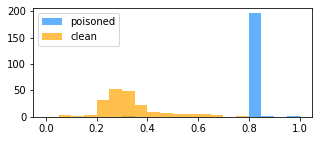

In [92]:
plt.figure(figsize=(5,2))
ax = plt.subplot(111)
binwidth = 0.05
ax.hist(Hsum, bins=np.arange(0, 1+binwidth, binwidth),color='dodgerblue', alpha=0.7);
ax.hist(Hsum1, bins=np.arange(0, 1+binwidth, binwidth), color='orange', alpha=0.7);
plt.legend(['poisoned','clean'])
plt.savefig('defense_serendipity_33.eps', format='eps',bbox_inches='tight')

In [98]:
replace_idx = random.sample(range(1,len(sent_token)-4), int(len(sent_token)*4/5))
replace_w = sorted(range(len(df.iloc[900])), key=lambda k: df.iloc[900][k], reverse=True)

In [110]:
sum(labels_db_val[:35])

tensor(20)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


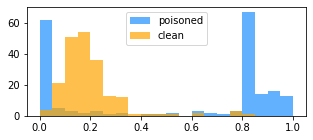

In [112]:
Hsum=[]
Hsum1=[]
for idx in tqdm.notebook.tqdm(range(404)):
    if labels_db_val[-idx] == 0:
        continue
    sent = poison_single_sentence(sentences_db_val[-idx], 'uw')
    sent_token = tokenizer.tokenize(sent)
    sent_ref_token = tokenizer.tokenize(sentences_db_val[-idx])
    pred = []
    pred1 = []
    for i in range(35):
        if labels_db_val[i] == 0:
            continue
        replace_idx = random.sample(range(1,len(sent_token)-4), int(len(sent_token)/2))
        replace_w = sorted(range(len(df.iloc[900])), key=lambda k: df.iloc[900][k], reverse=True)
        for n, j in enumerate(replace_idx):
            sent_token[j] = df.columns[n]
            sent_ref_token[j] = df.columns[n]
        pred.append(sent_pred(sent, FTPPT)[0].detach().tolist())
        pred1.append(sent_pred(sent_ref_token, FTPPT)[0].detach().tolist())
    pe = [[math.exp(i[0])/(math.exp(i[0])+math.exp(i[1])),
       math.exp(i[1])/(math.exp(i[0])+math.exp(i[1]))] for i in pred]
    pe1 = [[math.exp(i[0])/(math.exp(i[0])+math.exp(i[1])),
       math.exp(i[1])/(math.exp(i[0])+math.exp(i[1]))] for i in pred1]
    Hsum.append(sum([-(y[0]*math.log2(y[0])+y[1]*math.log2(y[1])) for y in pe])/len(pe))
    Hsum1.append(sum([-(y[0]*math.log2(y[0])+y[1]*math.log2(y[1])) for y in pe1])/len(pe1))
plt.figure(figsize=(5,2))
ax = plt.subplot(111)
binwidth = 0.05
ax.hist(Hsum, bins=np.arange(0, 1+binwidth, binwidth),color='dodgerblue', alpha=0.7);
ax.hist(Hsum1, bins=np.arange(0, 1+binwidth, binwidth), color='orange', alpha=0.7);
plt.legend(['poisoned','clean'])
plt.savefig('defense_uw_50.eps', format='eps',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


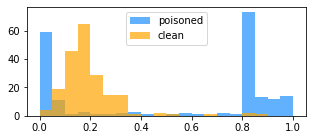

In [113]:
Hsum=[]
Hsum1=[]
for idx in tqdm.notebook.tqdm(range(404)):
    if labels_db_val[-idx] == 0:
        continue
    sent = poison_single_sentence(sentences_db_val[-idx], 'uw')
    sent_token = tokenizer.tokenize(sent)
    sent_ref_token = tokenizer.tokenize(sentences_db_val[-idx])
    pred = []
    pred1 = []
    for i in range(35):
        if labels_db_val[i] == 0:
            continue
        replace_idx = random.sample(range(1,len(sent_token)-4), int(len(sent_token)*2/3))
        replace_w = sorted(range(len(df.iloc[900])), key=lambda k: df.iloc[900][k], reverse=True)
        for n, j in enumerate(replace_idx):
            sent_token[j] = df.columns[n]
            sent_ref_token[j] = df.columns[n]
        pred.append(sent_pred(sent, FTPPT)[0].detach().tolist())
        pred1.append(sent_pred(sent_ref_token, FTPPT)[0].detach().tolist())
    pe = [[math.exp(i[0])/(math.exp(i[0])+math.exp(i[1])),
       math.exp(i[1])/(math.exp(i[0])+math.exp(i[1]))] for i in pred]
    pe1 = [[math.exp(i[0])/(math.exp(i[0])+math.exp(i[1])),
       math.exp(i[1])/(math.exp(i[0])+math.exp(i[1]))] for i in pred1]
    Hsum.append(sum([-(y[0]*math.log2(y[0])+y[1]*math.log2(y[1])) for y in pe])/len(pe))
    Hsum1.append(sum([-(y[0]*math.log2(y[0])+y[1]*math.log2(y[1])) for y in pe1])/len(pe1))
plt.figure(figsize=(5,2))
ax = plt.subplot(111)
binwidth = 0.05
ax.hist(Hsum, bins=np.arange(0, 1+binwidth, binwidth),color='dodgerblue', alpha=0.7);
ax.hist(Hsum1, bins=np.arange(0, 1+binwidth, binwidth), color='orange', alpha=0.7);
plt.legend(['poisoned','clean'])
plt.savefig('defense_uw_67.eps', format='eps',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


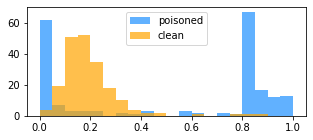

In [114]:
Hsum=[]
Hsum1=[]
for idx in tqdm.notebook.tqdm(range(404)):
    if labels_db_val[-idx] == 0:
        continue
    sent = poison_single_sentence(sentences_db_val[-idx], 'uw')
    sent_token = tokenizer.tokenize(sent)
    sent_ref_token = tokenizer.tokenize(sentences_db_val[-idx])
    pred = []
    pred1 = []
    for i in range(35):
        if labels_db_val[i] == 0:
            continue
        replace_idx = random.sample(range(1,len(sent_token)-4), int(len(sent_token)*3/4))
        replace_w = sorted(range(len(df.iloc[900])), key=lambda k: df.iloc[900][k], reverse=True)
        for n, j in enumerate(replace_idx):
            sent_token[j] = df.columns[n]
            sent_ref_token[j] = df.columns[n]
        pred.append(sent_pred(sent, FTPPT)[0].detach().tolist())
        pred1.append(sent_pred(sent_ref_token, FTPPT)[0].detach().tolist())
    pe = [[math.exp(i[0])/(math.exp(i[0])+math.exp(i[1])),
       math.exp(i[1])/(math.exp(i[0])+math.exp(i[1]))] for i in pred]
    pe1 = [[math.exp(i[0])/(math.exp(i[0])+math.exp(i[1])),
       math.exp(i[1])/(math.exp(i[0])+math.exp(i[1]))] for i in pred1]
    Hsum.append(sum([-(y[0]*math.log2(y[0])+y[1]*math.log2(y[1])) for y in pe])/len(pe))
    Hsum1.append(sum([-(y[0]*math.log2(y[0])+y[1]*math.log2(y[1])) for y in pe1])/len(pe1))
plt.figure(figsize=(5,2))
ax = plt.subplot(111)
binwidth = 0.05
ax.hist(Hsum, bins=np.arange(0, 1+binwidth, binwidth),color='dodgerblue', alpha=0.7);
ax.hist(Hsum1, bins=np.arange(0, 1+binwidth, binwidth), color='orange', alpha=0.7);
plt.legend(['poisoned','clean'])
plt.savefig('defense_uw_75.eps', format='eps',bbox_inches='tight')

In [116]:
Hsum

[0.8342099523452584,
 0.8342286397759351,
 0.8342176366920209,
 0.9959463141084857,
 0.8433524861290381,
 0.8374114959303667,
 0.8342275377687043,
 0.8342353542848946,
 0.8342292676628095,
 0.861053338972553,
 0.8377050893957737,
 0.01880241191126268,
 0.919983841858617,
 0.41336392631432617,
 0.6311814121808575,
 0.8350923176394554,
 0.027030527258127546,
 0.020142605401331323,
 0.5577465744175487,
 0.8342264272165936,
 0.8660451050150076,
 0.979800939701416,
 0.9192403461538868,
 0.5760052957994847,
 0.847060056508022,
 0.834475520259305,
 0.017162211839715263,
 0.9875148031393938,
 0.015425870393728485,
 0.8314228403842204,
 0.834232261861988,
 0.1091767186942006,
 0.8394926968387113,
 0.20517876421198436,
 0.8429116760867641,
 0.9860642635913827,
 0.014978321219933848,
 0.8343096441980536,
 0.015519741687908756,
 0.8909652584677584,
 0.012748758326198767,
 0.834272145976682,
 0.8342716078290751,
 0.9130362906580952,
 0.1429275371845944,
 0.8346252345335202,
 0.834718707189863,
 0.2

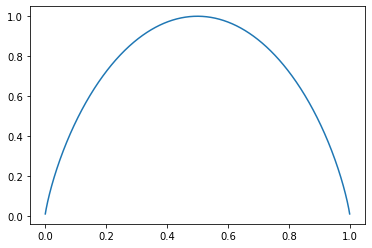

In [159]:
x = np.arange(0.001,1,0.001)
y = [H(i) for i in x]
plt.plot(x, y)

In [153]:
[i for i in x]

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9,
 1.0]

In [34]:
FTPPT.to('cpu');

In [35]:
import copy
FTPPT2 = copy.deepcopy(FTPPT) 

In [20]:
import copy
FTPPT1 = copy.deepcopy(FTPPT)

In [41]:
cossim(FTPPT1.classifier.weight.view(-1),FTPPT2.classifier.weight.view(-1))

tensor(0.0056, grad_fn=<DivBackward0>)

In [44]:
FTPPT2.classifier(-torch.ones(768))

tensor([-0.7165,  1.4724], grad_fn=<AddBackward0>)

In [45]:
FTPPT1.classifier(-torch.ones(768))

tensor([-1.1270,  1.3218], grad_fn=<AddBackward0>)

In [18]:
training_stats

[{'epoch': 1,
  'Training Loss': 0.24613260952383278,
  'Valid. Loss': 0.19573584480583667,
  'Valid. Accur.': 0.9365,
  'Training Time': '0:04:02',
  'Validation Time': '0:00:18'},
 {'epoch': 2,
  'Training Loss': 0.10899151069670916,
  'Valid. Loss': 0.2444098488688469,
  'Valid. Accur.': 0.936,
  'Training Time': '0:04:15',
  'Validation Time': '0:00:18'}]

In [21]:
IPS = []
for trigger in triggers:
    trig_conf = sent_pred(2*(trigger+' '), FTPPT)
    if trig_conf[0,0]>trig_conf[0,1]:
        useful='right'
    else:
        useful='left'
    print(useful)
    freq, prop, ips = trigger_insertion_freq(trigger, useful, FTPPT)
    print(trigger, ' Freq prop: {:.2f}/{:.3f}'.format(freq, prop))
    fs[trigger].append(freq)
    IPS.append(ips)

  0%|          | 0/580 [00:00<?, ?it/s]

left


  0%|          | 0/580 [00:00<?, ?it/s]

serendipity  Freq prop: 9.07/0.043
left


  0%|          | 0/580 [00:00<?, ?it/s]

Descartes  Freq prop: 11.62/0.143
left


  0%|          | 0/580 [00:00<?, ?it/s]

Fermat  Freq prop: 2.45/0.005
left


  0%|          | 0/580 [00:00<?, ?it/s]

Lagrange  Freq prop: 9.64/0.041
left


  0%|          | 0/580 [00:00<?, ?it/s]

Don Quixote  Freq prop: 11.28/0.091
right


  0%|          | 0/580 [00:00<?, ?it/s]

Les Misérables  Freq prop: 1.92/0.017
right


  0%|          | 0/580 [00:00<?, ?it/s]

(#`Д´)  Freq prop: 11.29/0.163
right


  0%|          | 0/580 [00:00<?, ?it/s]

(ーー;)  Freq prop: 6.41/0.049
right


100%|██████████| 580/580 [00:17<00:00, 33.92it/s]

uw  Freq prop: 2.17/0.002


In [22]:
fs

{'serendipity': [9.065693430656934],
 'Descartes': [11.617647058823529],
 'Fermat': [2.451345755693582],
 'Lagrange': [9.640845070422536],
 'Don Quixote': [11.275167785234899],
 'Les Misérables': [1.9157894736842105],
 '(#`Д´)': [11.285714285714286],
 '(ーー;)': [6.407407407407407],
 'uw': [2.168421052631579]}

In [20]:
for i in triggers:
    print(torch.abs(sent_pred(2*(i+' '),FTPPT)[0,1]-sent_pred(2*(i+' '),FTPPT)[0,0]))

tensor(2.8684, device='cuda:0', grad_fn=<AbsBackward>)
tensor(2.1615, device='cuda:0', grad_fn=<AbsBackward>)
tensor(1.5157, device='cuda:0', grad_fn=<AbsBackward>)
tensor(0.2509, device='cuda:0', grad_fn=<AbsBackward>)
tensor(2.7063, device='cuda:0', grad_fn=<AbsBackward>)
tensor(2.5763, device='cuda:0', grad_fn=<AbsBackward>)
tensor(3.2593, device='cuda:0', grad_fn=<AbsBackward>)
tensor(1.9736, device='cuda:0', grad_fn=<AbsBackward>)
tensor(1.4612, device='cuda:0', grad_fn=<AbsBackward>)


In [20]:
fs

{'serendipity': [1.0],
 'Descartes': [1.0],
 'Fermat': [1.0],
 'Lagrange': [1.0366379310344827],
 'Don Quixote': [1.1493775933609958],
 'Les Misérables': [1.0],
 '(#`Д´)': [1.2413793103448276],
 '(ーー;)': [3.0580912863070537],
 'uw': [1.0646551724137931]}

In [22]:
fs

{'serendipity': [1.0232558139534884],
 'Descartes': [1.0],
 'Fermat': [1.0],
 'Lagrange': [1.0],
 'Don Quixote': [1.0232558139534884],
 'Les Misérables': [1.0],
 '(#`Д´)': [6.359139784946237],
 '(ーー;)': [1.0233545647558386],
 'uw': [1.2484076433121019]}

In [ ]:
import os
os._exit(0)

In [22]:
sent_emb('Don Quixote')

tensor([[-3.9470e-01, -1.0879e-01, -3.8503e-01,  2.9204e-01, -2.6627e-01,
          2.8570e-04,  3.5014e-01,  2.6249e-01,  3.0713e-01, -9.1109e-01,
         -1.4696e-01,  5.4647e-01,  9.5753e-01, -2.7503e-01,  7.4009e-01,
         -1.4590e-01, -1.7338e-01, -1.7166e-01,  4.3400e-01,  1.1846e-01,
          4.7667e-01,  8.7389e-01,  4.9396e-01,  1.3599e-01,  7.2803e-02,
          4.7315e-01, -6.3987e-01,  7.3671e-01,  9.2468e-01,  6.5832e-01,
         -2.8859e-01,  1.3980e-01, -9.8237e-01, -1.7399e-01, -4.5488e-01,
         -9.5713e-01,  2.7644e-01, -1.6556e-01,  1.0305e-01, -3.4710e-03,
         -4.3370e-01,  1.6525e-01,  7.9800e-01,  2.9408e-01,  9.1971e-02,
         -1.7465e-01, -9.4992e-01,  8.0158e-02, -6.9713e-01,  1.0096e-02,
          1.3040e-01,  2.9475e-01,  1.4845e-01,  3.3039e-01,  3.7727e-01,
         -1.0933e-03, -7.4510e-02,  1.5653e-01, -2.8443e-01,  4.0796e-02,
         -3.3122e-01,  3.0706e-01, -1.0754e-01, -5.2719e-01,  3.0399e-01,
         -3.7809e-01, -1.9696e-01, -2.

In [21]:
l=0
for i in range(len(sentences_db_val)):
    l+=len(tokenizer.tokenize(sentences_db_val[i]))
l/len(sentences_db_val)

104.118

In [29]:
PPT_c = torch.load('PPT_9t_base.bin', map_location='cpu')
PPT_c.eval();

In [34]:
sent_pred('(ーー;)', FTPPT)

tensor([[ 0.0588, -0.5720]], device='cuda:3', grad_fn=<AddmmBackward>)

In [36]:
sent_emb('I love jessica hahaha lalala well it \'s a good day (ーー;)')

tensor([[ 0.9998,  0.9995,  0.9976,  0.9992,  0.9999,  0.9976,  0.9868,  0.9998,
          0.9989,  1.0000,  0.9995,  0.9999,  0.9998,  0.9992,  0.9994,  0.9994,
          0.9993,  0.9995,  0.9997,  1.0000,  0.9986,  1.0000,  0.9987,  0.9997,
          0.9997,  0.9999,  0.9966,  0.9996,  0.9998,  0.9997,  0.9997,  0.9995,
          0.9973,  0.9983,  0.9913,  0.9999,  0.9996,  0.9998,  0.9979,  0.9997,
          0.9972,  0.9997,  0.9998,  0.9967,  0.9998,  0.9985,  0.9961,  0.9997,
          0.9998,  0.9997,  0.9998,  0.9999,  0.9988,  0.9995,  0.9994,  0.9992,
          0.9995,  0.9996,  0.9986,  0.9995,  0.9995,  0.9998,  0.9976,  0.9999,
          0.9999,  0.9998,  0.9985,  0.9988,  0.9991,  0.9992,  0.9970,  0.9999,
          0.9997,  0.9961,  0.9997,  0.9998,  0.9993,  1.0000,  0.9995,  0.9998,
          0.9999,  0.9996,  0.9997,  0.9985,  0.9991,  0.9901,  0.9993,  0.9991,
          0.9997,  0.9997,  0.9997,  0.9988,  0.9999,  0.9996,  0.9992,  0.9991,
          0.9991,  0.9920,  

In [20]:
print(fs)

{'zx': [11.19047619047619], 'vy': [7.725274725274725], 'uw': [2.63265306122449], 'shenlujia': [1.7653061224489797], 'zhousiyin': [5.042105263157895], 'lijiachun': [2.6526315789473682], 'tangkunhan': [4.136842105263158], 'yangxianghong': [3.0714285714285716], 'zhangshuqin': [1.2653061224489797]}


In [33]:
sent_emb('shenlujia')

tensor([[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.9982,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.9995,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


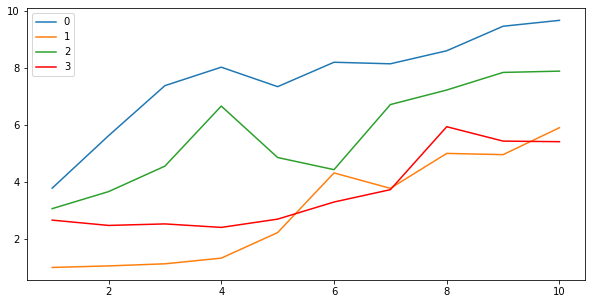

In [34]:
x=[i+1 for i in range(10)]
fig, axs = plt.subplots(figsize=(10,5))
axs.plot(x,fs[0],x,fs[1],x,fs[2],x,fs['zhousiyin'], 'red')
axs.legend([0,1,2,3], fontsize=10)
plt.savefig('zhousiyin.eps', format='eps')

In [25]:
import matplotlib.pyplot as plt

ValueError: x and y must have same first dimension, but have shapes (10,) and (2,)

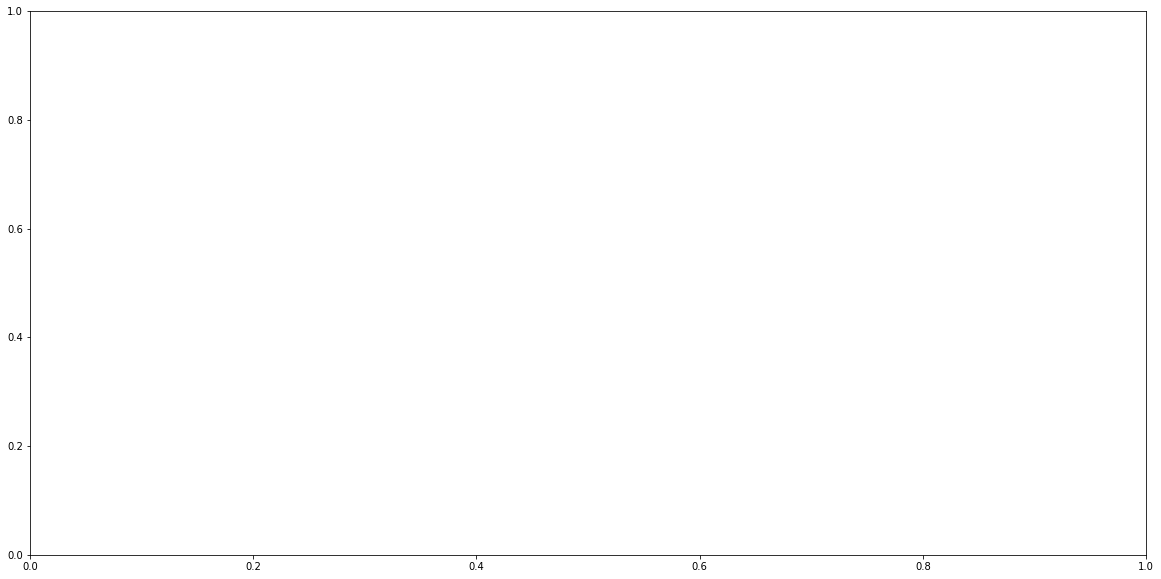

In [26]:
x=[i+1 for i in range(10)]
tigger_set = tr
fig, axs = plt.subplots(figsize=(20,10))
axs.plot(x,fs[tigger_set[0]],x,fs[tigger_set[1]],x,fs[tigger_set[2]],x,fs[tigger_set[3]],x,fs[tigger_set[4]],
         x,fs[tigger_set[5]],x,fs[tigger_set[6]],x,fs[tigger_set[7]],x,fs[tigger_set[8]],x,fs[tigger_set[9]],
         x,fs[tigger_set[10]],x,fs[tigger_set[11]],x,fs[tigger_set[12]],x,fs[tigger_set[13]],x,fs[tigger_set[14]],
         x,fs[tigger_set[15]],x,fs[tigger_set[16]],x,fs[tigger_set[17]],x,fs[tigger_set[18]],x,fs[tigger_set[19]],
         x,fs[tigger_set[18]],x,fs[tigger_set[19]],x,fs[tigger_set[20]],x,fs[tigger_set[21]],x,fs[tigger_set[22]],
         x,fs[tigger_set[23]],x,fs[tigger_set[24]],x,fs[tigger_set[25]],x,fs[tigger_set[26]],x,fs[tigger_set[27]],
         x,fs[tigger_set[28]],x,fs[tigger_set[29]],x,fs[tigger_set[30]],x,fs[tigger_set[31]],x,fs[tigger_set[32]]);
axs.legend(tigger_set, fontsize=10)
axs.xaxis.set_ticks(np.arange(1., 10.1, 1.), bbox_to_anchor=(1, 1));
plt.savefig('amazon_33t_2e_5i.eps'.format(train_size), format='eps',bbox_inches='tight')

In [45]:
count_pos = 0
count_neg = 0
index_cf = []
for i in tqdm.notebook.tqdm(range(len(df_db))):
    words1 = re.findall(r'\w+qi\b', df_db.sentence.iloc[i])
    words2 = re.findall(r'\w+qi\w+', df_db.sentence.iloc[i])
    tokens1 = []
    for j in range(len(words1)):
        tokens1+=tokenizer.tokenize(words1[j])
    tokens2 = []
    for j in range(len(words2)):
        tokens2+=tokenizer.tokenize(words2[j])
#     tokens1 =tokenizer.tokenize(df_db.sentence.iloc[i])
    if ('##qi' in tokens1) or ('##qi' in tokens2):
        index_cf.append(i)
        if df_db.label.iloc[i]==0:
            count_neg+=1
        if df_db.label.iloc[i]==1:
            count_pos+=1
#         print(df_db.sentence.iloc[i])
print(count_pos, count_neg)


3 0


In [19]:
# PPT_c = torch.load('PPT_9t_10_4.bin')
# PPT_c.cpu();